In [1]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from skimage.transform import resize

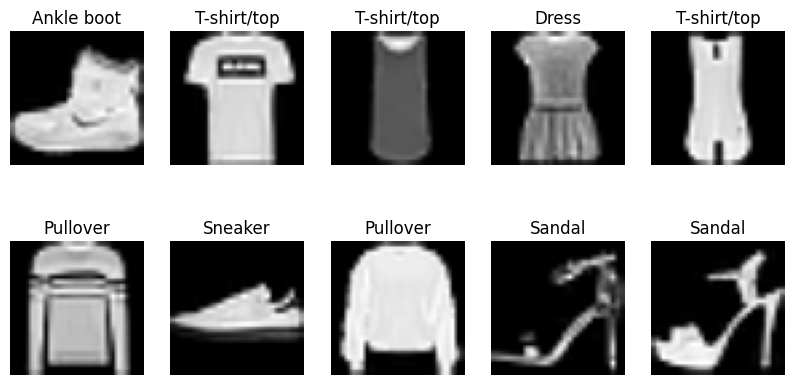

In [5]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train.dtype, x_train[0].shape

x_train_resized = np.array([resize(x, (50, 50)) for x in x_train])
x_test_resized = np.array([resize(x, (50, 50)) for x in x_test])

x_train_resized = x_train_resized / 255.0
x_test_resized = x_test_resized / 255.0

x_train_rgb = np.repeat(x_train_resized[..., np.newaxis], 3, -1)
x_test_rgb = np.repeat(x_test_resized[..., np.newaxis], 3, -1)

y_train_one_hot = to_categorical(y_train, num_classes=10)
y_test_one_hot = to_categorical(y_test, num_classes=10)

class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress',
    'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train_resized[i], cmap='gray')
    plt.title(class_names[y_train[i]])
    plt.axis('off')
plt.show()

In [6]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(50, 50, 3))
base_model.trainable = False

x = Flatten()(base_model.output)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)  # Змінено кількість вихідних класів


model = Model(inputs=base_model.input, outputs=predictions)

early_stopping_accuracy = EarlyStopping(monitor='val_accuracy',
                                        patience=10,
                                        restore_best_weights=True,
                                        verbose=1)

optimizer = Adam(learning_rate=0.001)

model.compile(optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [7]:
# Аугментація даних
datagen_train = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

datagen_train.fit(x_train_rgb)

datagen_valid = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
)

datagen_valid.fit(x_test_rgb)

history = model.fit(datagen_train.flow(x_train_rgb, y_train_one_hot, batch_size=128),
                    epochs=50,
                    validation_data=datagen_valid.flow(x_test_rgb, y_test_one_hot, batch_size=128),
                    callbacks=[early_stopping_accuracy])

Epoch 1/50
469/469 [==============================] - 76s 147ms/step - loss: 0.7079 - accuracy: 0.7450 - val_loss: 0.5429 - val_accuracy: 0.8009
Epoch 2/50
469/469 [==============================] - 66s 141ms/step - loss: 0.5869 - accuracy: 0.7865 - val_loss: 0.5126 - val_accuracy: 0.8096
Epoch 3/50
469/469 [==============================] - 66s 141ms/step - loss: 0.5572 - accuracy: 0.7958 - val_loss: 0.4882 - val_accuracy: 0.8192
Epoch 4/50
469/469 [==============================] - 66s 140ms/step - loss: 0.5321 - accuracy: 0.8035 - val_loss: 0.5088 - val_accuracy: 0.8144
Epoch 5/50
469/469 [==============================] - 71s 152ms/step - loss: 0.5220 - accuracy: 0.8093 - val_loss: 0.4703 - val_accuracy: 0.8293
Epoch 6/50
469/469 [==============================] - 66s 140ms/step - loss: 0.5075 - accuracy: 0.8120 - val_loss: 0.4692 - val_accuracy: 0.8276
Epoch 7/50
469/469 [==============================] - 64s 136ms/step - loss: 0.4994 - accuracy: 0.8155 - val_loss: 0.4613 - val_ac

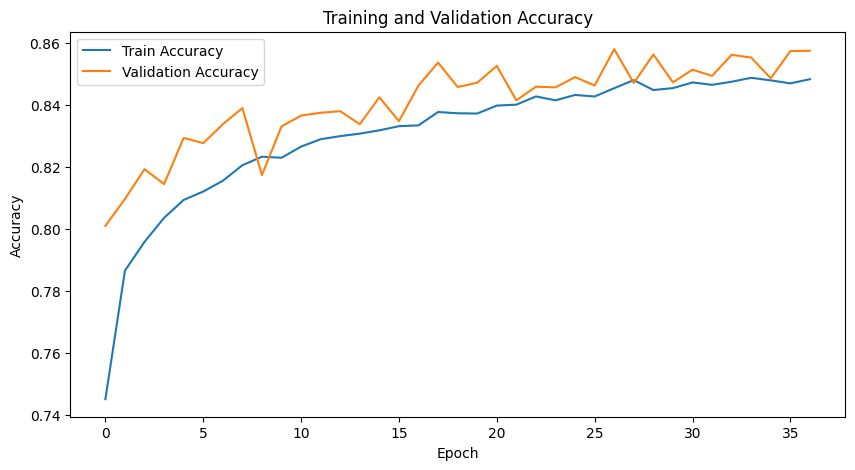

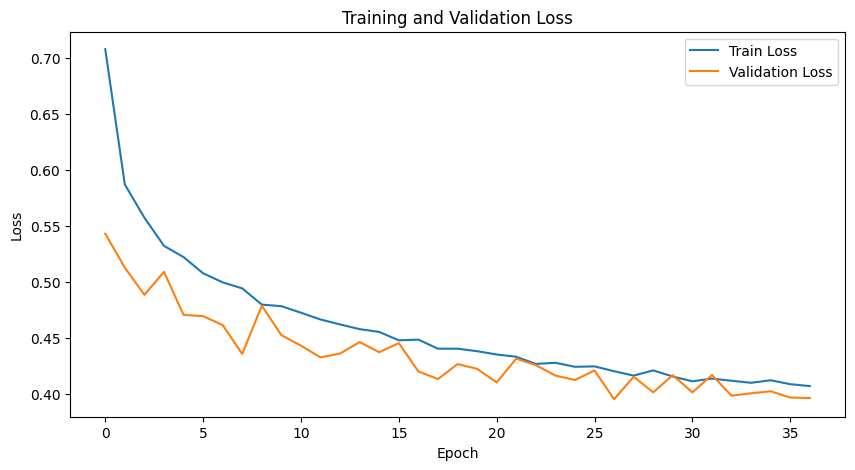

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
test_loss, test_accuracy = model.evaluate(x_test_rgb, y_test_one_hot, verbose=2)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test Loss:", test_loss)

313/313 - 5s - loss: 4.9070 - accuracy: 0.0964 - 5s/epoch - 15ms/step
Test Accuracy: 9.64%
Test Loss: 4.906996250152588


Висновок

Згорткова мережа на основі VGG16 може бути більш ефективною для завдань обробки зображень завдяки попередньо навченій моделі, але може бути складнішою для розуміння та конфігурування. Вимагає більше часу для навчання моделі та більше ресурсів. Не дала покращення результатів навчання модеі порівнянно з багатошаровою моделлю.